In [12]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set_style(style='whitegrid')
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

In [2]:
def calculate_pvalues(df):
    from scipy.stats import pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [50]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
df = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0)
df_ladies = df[df['Sex'] == 'F']
df_ladies = df_ladies.drop('Sex', axis=1)
df_dudes = df[df['Sex'] == 'M']
df_dudes = df_dudes.drop('Sex', axis=1)

df_ladies['const'] = 1
df_dudes['const'] = 1

In [18]:
subjects = phy_rt_df.index.values
print(subjects)

[101 102 103 104 106 107 108 110 212 214 215 216 217 218 219 320 321 323
 324 325 327 328 330 331 333 334 335 336 337 338 339 340 341 342 343 344
 345 346 347 348 349 350 451 453 455 457 458 459 460 462 463 464 465 467
 468 469 470 502 503 571 572 573 574 577 578 581 582 584 585 586 587 588
 589 591 592 593 594 595 596 597 598 604 605 606 607 608 609 610 612 613
 614 615 617 618 619 620 621 622 623 624 625 626 627 629 630 631 633 634]


In [20]:
phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
gen_rt_df = pd.read_csv(join(data_dir, 'retr_gencond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)

phy_rt_df.drop('index', axis=1, inplace=True)
phy_rt_df.drop('Session', axis=1, inplace=True)
phy_rt_df.drop('Class', axis=1, inplace=True)
phy_rt_df.drop('Gender And Class', axis=1, inplace=True)
phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)


gen_rt_df.drop('index', axis=1, inplace=True)
gen_rt_df.drop('Gender And Class', axis=1, inplace=True)
gen_rt_df.drop('Class', axis=1, inplace=True)
gen_rt_df.drop('Session', axis=1, inplace=True)
gen_rt_df.rename({'Mean Correct RT': 'Mean Correct General RT',
                  'Mean Incorrect RT': 'Mean Incorrect General RT'}, axis=1, inplace=True)

In [21]:
rt_acc_df = pd.concat([phy_rt_df, gen_rt_df], axis=1)
rt_acc_df.head()

,Mean Physics Retrieval Accuracy,Mean Correct Physics RT,Mean Incorrect Physics RT,Gender,Mean General Retrieval Accuracy,Mean Correct General RT,Mean Incorrect General RT,Gender
Subject,,,,,,,,
101,0.750000,4280.277778,2958.50,F,0.958333,3550.086957,4235.0,F
102,0.833333,4387.000000,1459.75,M,0.916667,3160.772727,3412.0,M
103,0.875000,4388.571429,0.00,M,0.958333,3629.652174,0.0,M
104,0.708333,4978.705882,1198.00,F,0.916667,4114.318182,5413.0,F
106,0.833333,4230.750000,3801.50,M,0.958333,3382.391304,2269.0,M


In [22]:
all_df = pd.concat([df, rt_acc_df], axis=1)

In [9]:
ac_diff = ttest_ind(rt_acc_df['Mean Physics Retrieval Accuracy'], rt_acc_df['Mean General Retrieval Accuracy'])
print('Average Accuracy:\nPhysics: {0}\nGeneral: {1}\nt = {2}, p = {3}\n'.format(np.mean(rt_acc_df['Mean Physics Retrieval Accuracy']),
                                                                   np.mean(rt_acc_df['Mean General Retrieval Accuracy']),
                                                                   np.round(ac_diff.statistic,3), np.round(ac_diff.pvalue,20)))

Average Accuracy:
Physics: 0.765046296296287
General: 0.9320987654320279
t = -11.644, p = 0.0



In [11]:
rt_diff = ttest_ind(rt_acc_df['Mean Correct Physics RT'], rt_acc_df['Mean Correct General RT'])
print('Average Correct RT:\nPhysics: {0}\nGeneral: {1}\nt = {2}, p = {3}\n'.format(np.mean(rt_acc_df['Mean Correct Physics RT']),
                                                                   np.mean(rt_acc_df['Mean Correct General RT']),
                                                                   np.round(rt_diff.statistic,3), np.round(rt_diff.pvalue,20)))

Average Correct RT:
Physics: 4201.82824636213
General: 3359.23787080463
t = 13.4, p = 0.0



In [24]:
print(spearmanr(all_df['Full Scale IQ_2'], all_df['Mean Physics Retrieval Accuracy'], nan_policy='omit'),
      spearmanr(all_df['Full Scale IQ_2'], all_df['Mean General Retrieval Accuracy'], nan_policy='omit'),
      spearmanr(all_df['Full Scale IQ_2'], all_df['Mean Correct Physics RT'], nan_policy='omit'),
      spearmanr(all_df['Full Scale IQ_2'], all_df['Mean Correct General RT'], nan_policy='omit'))

SpearmanrResult(correlation=0.35356264437651685, pvalue=masked_array(data=0.00018717,
             mask=False,
       fill_value=1e+20)) SpearmanrResult(correlation=0.370887063024232, pvalue=masked_array(data=8.40172332e-05,
             mask=False,
       fill_value=1e+20)) SpearmanrResult(correlation=-0.2820196602628248, pvalue=masked_array(data=0.00325098,
             mask=False,
       fill_value=1e+20)) SpearmanrResult(correlation=-0.3176550103448678, pvalue=masked_array(data=0.00085592,
             mask=False,
       fill_value=1e+20))


In [44]:
phy_ac_diff = ttest_ind(rt_acc_df[rt_acc_df['Gender'] == 'F']['Mean Physics Retrieval Accuracy'], 
                    rt_acc_df[rt_acc_df['Gender'] == 'M']['Mean Physics Retrieval Accuracy'])
gen_ac_diff = ttest_ind(rt_acc_df[rt_acc_df['Gender'] == 'F']['Mean General Retrieval Accuracy'], 
                    rt_acc_df[rt_acc_df['Gender'] == 'M']['Mean General Retrieval Accuracy'])

In [43]:
print('Average Accuracy Physics:\nF: {0}\nM: {1}\nt = {2}, p = {3}\n'.format(np.mean(rt_acc_df[rt_acc_df['Gender'] == 'F']['Mean Physics Retrieval Accuracy']),
                                                                   np.mean(rt_acc_df[rt_acc_df['Gender'] == 'M']['Mean Physics Retrieval Accuracy']),
                                                                   np.round(phy_rt_diff.statistic,3), np.round(phy_rt_diff.pvalue,7)))
print('Average Accuracy General:\nF: {0}\nM: {1}\nt = {2}, p = {3}'.format(np.mean(rt_acc_df[rt_acc_df['Gender'] == 'F']['Mean General Retrieval Accuracy']),
                                                                   np.mean(rt_acc_df[rt_acc_df['Gender'] == 'M']['Mean General Retrieval Accuracy']),
                                                                   np.round(gen_ac_diff.statistic,3), np.round(gen_ac_diff.pvalue,7)))


Average Accuracy Physics:
F: 0.7170138888889167
M:0.8034722222221833
t = -3.92, p = 0.0001574

Average Accuracy General:
F: 0.9192708333332709
M:0.9423611111110335
t = -1.381, p = 0.1701053


In [76]:
phy_rt_corr = ttest_ind(phy_rt_df[phy_rt_df['Gender'] == 'F']['Mean Correct RT'], 
                    phy_rt_df[phy_rt_df['Gender'] == 'M']['Mean Correct RT'])
gen_rt_corr = ttest_ind(gen_rt_df[gen_rt_df['Gender'] == 'F']['Mean Correct RT'], 
                    gen_rt_df[gen_rt_df['Gender'] == 'M']['Mean Correct RT'])
phy_rt_inc = ttest_ind(phy_rt_df[phy_rt_df['Gender'] == 'F']['Mean Incorrect RT'], 
                    phy_rt_df[phy_rt_df['Gender'] == 'M']['Mean Incorrect RT'], nan_policy='omit')
gen_rt_inc = ttest_ind(gen_rt_df[gen_rt_df['Gender'] == 'F']['Mean Incorrect RT'], 
                    gen_rt_df[gen_rt_df['Gender'] == 'M']['Mean Incorrect RT'], nan_policy='omit')

print('Correct RT Physics:\nF: {0}\nM:{1}\nt = {2}, p = {3}\n'.format(np.mean(phy_rt_df[phy_rt_df['Gender'] == 'F']['Mean Correct RT']),
                                                                   np.mean(phy_rt_df[phy_rt_df['Gender'] == 'M']['Mean Correct RT']),
                                                                   np.round(phy_rt_corr.statistic,3), np.round(phy_rt_corr.pvalue,7)))
print('Correct RT General:\nF: {0}\nM:{1}\nt = {2}, p = {3}\n'.format(np.mean(gen_rt_df[gen_rt_df['Gender'] == 'F']['Mean Correct RT']),
                                                                   np.mean(gen_rt_df[gen_rt_df['Gender'] == 'M']['Mean Correct RT']),
                                                                   np.round(gen_rt_corr.statistic,3), np.round(gen_rt_corr.pvalue,7)))
print('Incorrect RT Physics:\nF: {0}\nM: {1}\nt = {2}, p = {3}\n'.format(np.mean(phy_rt_df[phy_rt_df['Gender'] == 'F']['Mean Incorrect RT']),
                                                                   np.mean(phy_rt_df[phy_rt_df['Gender'] == 'M']['Mean Incorrect RT']),
                                                                   np.round(phy_rt_inc.statistic,3), np.round(phy_rt_inc.pvalue,7)))
print('Incorrect RT General:\nF: {0}\nM: {1}\nt = {2}, p = {3}'.format(np.mean(gen_rt_df[gen_rt_df['Gender'] == 'F']['Mean Incorrect RT']),
                                                                   np.mean(gen_rt_df[gen_rt_df['Gender'] == 'M']['Mean Incorrect RT']),
                                                                   np.round(gen_rt_inc.statistic,3), np.round(gen_rt_inc.pvalue,7)))


Correct RT Physics:
F: 4321.633836693333
M:4105.983774097166
t = 2.598, p = 0.0107148

Correct RT General:
F: 3469.28680199375
M:3271.198725853333
t = 2.153, p = 0.0335735

Incorrect RT Physics:
F: 3219.0075998074994
M: 2912.728386699414
t = 1.298, p = 0.197072

Incorrect RT General:
F: 3295.8020900975002
M: 3100.1380341878717
t = 0.461, p = 0.6462343


In [16]:
rt_acc_df.drop(457,axis=0,inplace=True)

In [20]:
gen_rt_df.drop(457,axis=0,inplace=True)
phy_rt_df.drop(457,axis=0,inplace=True)

In [25]:
print('physics accuracy & IQ: {0}'.format(pearsonr(rt_acc_df['Mean Physics Retrieval Accuracy'], df['Full Scale IQ_2'])))
print('general accuracy & IQ: {0}'.format(pearsonr(rt_acc_df['Mean General Retrieval Accuracy'], df['Full Scale IQ_2'])))
print('physics RT & IQ: {0}'.format(pearsonr(phy_rt_df['Mean Correct RT'], df['Full Scale IQ_2'])))
print('general RT & IQ: {0}'.format(pearsonr(gen_rt_df['Mean Correct RT'], df['Full Scale IQ_2'])))
print('physics accuracy & grade: {0}'.format(pearsonr(rt_acc_df['Mean Physics Retrieval Accuracy'], df['Phy48Grade'])))
print('general accuracy & grade: {0}'.format(pearsonr(rt_acc_df['Mean General Retrieval Accuracy'], df['Phy48Grade'])))
print('physics RT & grade: {0}'.format(pearsonr(phy_rt_df['Mean Correct RT'], df['Phy48Grade'])))
print('general RT & grade: {0}'.format(pearsonr(gen_rt_df['Mean Correct RT'], df['Phy48Grade'])))
print(pearsonr(df['Phy48Grade'], df['Full Scale IQ_2']))
print(pearsonr(df['Phy48Grade'], df['Verbal Comprehension Sum_2']))
print(pearsonr(df['Phy48Grade'], df['Perceptual Reasoning Sum_2']))

physics accuracy & IQ: (0.3752528266641977, 6.816288156016615e-05)
general accuracy & IQ: (0.4133469609138019, 9.642741147958938e-06)
physics RT & IQ: (-0.34246914724871214, 0.0003053172178064077)
general RT & IQ: (-0.3206842052307582, 0.0007581938276354396)
physics accuracy & grade: (0.3240959667857466, 0.0006604218154970295)
general accuracy & grade: (-0.10243219750098624, 0.2937704244424711)
physics RT & grade: (-0.10041093571437526, 0.3034502234504024)
general RT & grade: (0.001372486576876949, 0.9888057563813832)
(0.11113852890197005, 0.2544289892826577)
(0.10418918917411495, 0.28552388866644)
(0.161882460603865, 0.0957404884921033)


In [165]:
df = df.replace({'M':0, 'F':1})
df['const'] = 1
df['sexXIQ'] = df['Sex'] * df['Full Scale IQ_2']
df['SexXGrade'] = df['Sex'] * df['Phy48Grade']

In [252]:
df.keys()

Index(['Sex', 'AgeOnScanDate', 'Phy48Grade', 'GPA.PreSem',
       'fc default mode-left central executive gen',
       'fc default mode-left central executive phy',
       'fc default mode-right central executive gen',
       'fc default mode-right central executive phy',
       'fc hippo-default mode gen', 'fc hippo-default mode phy',
       'fc hippo-left central executive gen',
       'fc hippo-left central executive phy',
       'fc hippo-right central executive gen',
       'fc hippo-right central executive phy',
       'fc left central executive-right central executive gen',
       'fc left central executive-right central executive phy',
       'global efficiency gen', 'global efficiency phy', 'le default mode gen',
       'le default mode phy', 'le left central executive gen',
       'le left central executive phy', 'le right central executive gen',
       'le right central executive phy', 'Verbal Comprehension Sum_2',
       'Perceptual Reasoning Sum_2', 'Full Scale IQ_2', 'con

In [37]:
conn = ['fc default mode-left central executive gen',
       'fc default mode-left central executive phy',
       'fc default mode-right central executive gen',
       'fc default mode-right central executive phy',
       'fc hippo-default mode gen', 'fc hippo-default mode phy',
       'fc hippo-left central executive gen',
       'fc hippo-left central executive phy',
       'fc hippo-right central executive gen',
       'fc hippo-right central executive phy',
       'fc left central executive-right central executive gen',
       'fc left central executive-right central executive phy']

In [38]:
eff = ['global efficiency gen', 'global efficiency phy', 'le default mode gen',
       'le default mode phy', 'le left central executive gen',
       'le left central executive phy', 'le right central executive gen',
       'le right central executive phy']

In [39]:
ntwk_labels = ['Limbic', 'Orbitofrontal', 'Basal Ganglia', 'Salience', 'Hunger', 
          'Motor Learning', 'Frontoparietal', 'Hand', 'Motor Execution', 'Higher Order Visual', 
          'Lateral Visual', 'Medial Visual', 'Default Mode',' Cerebellum', 'Central Executive (left)', 
          'Auditory', 'Mouth', 'Central Executive (right)']

regn_labels = ['limbic', 'limbic', 'orbitofrontal', 'orbitofrontal', 'basal ganglia',
          'salience', 'salience', 'salience', 'hunger', 'hunger', 'hunger',
          'hunger', 'hunger', 'hunger', 'hunger', 'motor learning', 'frontoparietal',
          'frontoparietal', 'frontoparietal', 'hand', 'hand', 'hand', 'motor execution',
          'motor execution', 'higher order visual', 'higher order visual',
          'lateral visual', 'lateral visual', 'medial visual', 'default mode',
          'default mode', 'default mode', 'default mode', 'default mode', ' cerebellum',
          'left central executive', 'left central executive', 'left central executive',
          'left central executive', 'left central executive', 'auditory', 'auditory',
          'mouth', 'mouth', 'right central executive', 'right central executive',
          'right central executive']

In [40]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212',
            '214', '215', '216', '217', '218', '219', '320', '321', '323',
            '324', '325', '327', '328', '330', '331', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '453', '455',
            '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574',
            '577', '578', '581', '582', '584', '585', '586', '587',
            '588', '589', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '612',
            '613', '614', '615', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '629', '630', '631', '633',
            '634']

#subjects = ['101', '102']

In [41]:
demo_iq = ['const', 'Sex', 'Full Scale IQ_2', 'sexXIQ']
academic = ['const', 'Sex', 'Phy48Grade', 'SexXGrade']
non_brain = ['const','Sex', 'Verbal Comprehension Sum_2', 'Perceptual Reasoning Sum_2', 
             'Full Scale IQ_2', 'sexXIQ', 'Phy48Grade', 'SexXGrade', 'AgeOnScanDate']
brain = conn + eff

## Mass univariate testing via permutations (defunct)
Retains all the dependencies of the initial data in the null distributions, often too conservative

In [215]:
#i want a mass univariate analysis of relationships between sex, IQ, and connectivity
conn_iqxsex = permuted_ols(df[demo_iq].values, df[conn].values, df['AgeOnScanDate'].values.reshape(107,1), 
                           model_intercept=True)
#i want a mass univariate analysis of relationships between sex, Grade, and connectivity
conn_gradexsex = permuted_ols(df[academic].values, df[conn].values, df['AgeOnScanDate'].values.reshape(107,1), 
                              model_intercept=True)
connectivity = pd.DataFrame({'Grade (all)': 10**-conn_gradexsex[0][1].T.reshape(12,), 
                             'IQ (all)': 10**-conn_iqxsex[0][1].T.reshape(12,),
                             'GradeXSex (all)': 10**-conn_gradexsex[0][2].T.reshape(12,), 
                             'IQXSex (all)': 10**-conn_iqxsex[0][2].T.reshape(12,)}, 
                            index=conn)

conn_iq_ladies = permuted_ols(df_ladies['Full Scale IQ_2'].values, df_ladies[conn].values, model_intercept=True)
connectivity['IQ (ladies)'] = 10**-conn_iq_ladies[0].T.reshape(12,)
conn_iq_dudes = permuted_ols(df_dudes['Full Scale IQ_2'].values, df_dudes[conn].values, model_intercept=True)
connectivity['IQ (dudes)'] = 10**-conn_iq_dudes[0].T.reshape(12,)

conn_grade_ladies = permuted_ols(df_ladies['Phy48Grade'].values, df_ladies[conn].values, model_intercept=True)
connectivity['Grade (ladies)'] = 10**-conn_grade_ladies[0].T.reshape(12,)
conn_grade_dudes = permuted_ols(df_dudes['Phy48Grade'].values, df_dudes[conn].values, model_intercept=True)
connectivity['Grade (dudes)'] = 10**-conn_grade_dudes[0].T.reshape(12,)

connectivity

,Grade (all),IQ (all),GradeXSex (all),IQXSex (all),IQ (ladies),IQ (dudes),Grade (ladies),Grade (dudes)
fc default mode-left central executive gen,1.000000,0.933507,1.000000,0.999900,0.915408,1.000000,0.999600,0.997400
fc default mode-left central executive phy,0.884312,0.999300,0.995500,0.965303,0.892411,0.541146,1.000000,0.514049
fc default mode-right central executive gen,0.972103,0.303870,0.998600,0.801120,0.445455,0.999900,0.524948,0.985201
fc default mode-right central executive phy,1.000000,1.000000,1.000000,0.999900,0.755624,0.998600,1.000000,1.000000
fc hippo-default mode gen,1.000000,1.000000,1.000000,0.999900,0.993401,1.000000,1.000000,1.000000
fc hippo-default mode phy,0.497350,1.000000,0.739526,0.230577,0.832617,0.999900,0.990401,0.824818
fc hippo-left central executive gen,0.975002,0.999500,1.000000,1.000000,0.987401,1.000000,1.000000,0.787221
fc hippo-left central executive phy,0.707729,0.999900,0.447655,0.163084,0.807219,0.973903,1.000000,0.778922
fc hippo-right central executive gen,1.000000,0.843616,1.000000,1.000000,0.748425,1.000000,0.999900,1.000000
fc hippo-right central executive phy,0.995100,0.998000,0.998500,0.876412,0.503350,1.000000,0.999900,1.000000


In [216]:
#i want a mass univariate analysis of relationships between sex, Grade, and efficiency
eff_gradexsex = permuted_ols(df[academic].values, df[eff].values, 
                             df['AgeOnScanDate'].values.reshape(107,1), 
                             model_intercept=True)

#i want a mass univariate analysis of relationships between sex, IQ, and efficiency
eff_iqxsex = permuted_ols(df[demo_iq].values, df[eff].values, 
                          df['AgeOnScanDate'].values.reshape(107,1), 
                          model_intercept=True)
efficiency = pd.DataFrame({'Grade (all)': 10**-eff_gradexsex[0][1].T.reshape(8,), 
                           'IQ (all)': 10**-eff_iqxsex[0][1].T.reshape(8,),
                           'GradeXSex (all)': 10**-eff_gradexsex[0][2].T.reshape(8,), 
                           'IQXSex (all)': 10**-eff_iqxsex[0][2].T.reshape(8,)}, 
                          index=eff)

eff_ladies_grade = permuted_ols(df_ladies['Phy48Grade'].values, df_ladies[eff].values, 
                                df_ladies['AgeOnScanDate'].values.reshape(48,1), 
                                model_intercept=True)
eff_ladies_iq = permuted_ols(df_ladies['Full Scale IQ_2'].values, df_ladies[eff].values, 
                             df_ladies['AgeOnScanDate'].values.reshape(48,1), 
                             model_intercept=True)
efficiency['Grade (ladies)'] = 10**-eff_ladies_grade[0].T.reshape(8,)
efficiency['IQ (ladies)'] = 10**-eff_ladies_iq[0].T.reshape(8,)
                           
eff_dudes_grade = permuted_ols(df_dudes['Phy48Grade'].values, df_dudes[eff].values, 
                               df_dudes['AgeOnScanDate'].values.reshape(59,1), 
                               model_intercept=True)
eff_dudes_iq = permuted_ols(df_dudes['Full Scale IQ_2'].values, df_dudes[eff].values, 
                            df_dudes['AgeOnScanDate'].values.reshape(59,1), 
                            model_intercept=True)
efficiency['Grade (dudes)'] = 10**-eff_dudes_grade[0].T.reshape(8,)
efficiency['IQ (dudes)'] = 10**-eff_dudes_iq[0].T.reshape(8,)

efficiency

,Grade (all),IQ (all),GradeXSex (all),IQXSex (all),Grade (ladies),IQ (ladies),Grade (dudes),IQ (dudes)
global efficiency gen,0.985501,0.606939,0.392261,0.416658,1.000000,0.697230,0.595940,1.000000
global efficiency phy,0.653935,0.995600,0.999600,1.000000,1.000000,0.453355,0.207579,0.990301
le default mode gen,0.638836,0.435356,0.999800,0.958204,0.675432,0.496850,0.998000,1.000000
le default mode phy,1.000000,1.000000,1.000000,1.000000,0.997800,0.705429,0.971803,0.726527
le left central executive gen,1.000000,0.496550,0.583642,0.515648,0.996700,0.245175,0.780122,1.000000
le left central executive phy,0.630637,0.997700,0.998900,0.982602,0.968903,0.522448,0.053495,0.996900
le right central executive gen,0.949605,0.999500,0.999800,0.997900,0.999200,0.329467,0.600940,0.999600
le right central executive phy,1.000000,0.984402,1.000000,1.000000,1.000000,0.143786,1.000000,0.962804


In [57]:
jili_sidak_mc(df_dudes[brain], 0.05)

Number of effective comparisons: 9.196346786886647
Critical value of 0.050 becomes 0.005562 after corrections


(0.005562047094206046, 9.196346786886647)

In [58]:
jili_sidak_mc(df_ladies[brain], 0.05)

Number of effective comparisons: 8.094224143403657
Critical value of 0.050 becomes 0.006317 after corrections


(0.006316987622182135, 8.094224143403657)

In [59]:
jili_sidak_mc(df[brain], 0.05)

Number of effective comparisons: 9.083483606106961
Critical value of 0.050 becomes 0.005631 after corrections


(0.0056309611395894965, 9.083483606106961)

In [294]:
pearsonr(df['Phy48Grade'], df['Perceptual Reasoning Sum_2'])

(0.161882460603865, 0.0957404884921033)

## So, instead of mass univariate + permutations, we'll do a JiLi-Sidak correction and proceed accordingly

In [259]:
#first, let's test for multicollinearity among non-brain variables
non_brain_corr = df[non_brain].corr()
for key in non_brain_corr.keys():
    for index in non_brain_corr.index:
        if non_brain_corr[key][index] > 0.7:
            if key != index:
                print(key, 'is collinear with', index)

Sex is collinear with sexXIQ
Sex is collinear with SexXGrade
Perceptual Reasoning Sum_2 is collinear with Full Scale IQ_2
Full Scale IQ_2 is collinear with Perceptual Reasoning Sum_2
sexXIQ is collinear with Sex
sexXIQ is collinear with SexXGrade
SexXGrade is collinear with Sex
SexXGrade is collinear with sexXIQ


In [285]:
bic_iq = {}
pval_iq = {}
f_pval_iq = {}

for brain_var in brain_vars:
    print('******************************{0}********************************'.format(brain_var))
    model = sm.OLS(df[brain_var]*100, df[demo_iq], hasconst=True).fit()
    print(model.summary())
    bic_iq[brain_var] = model.bic
    pval_iq[brain_var] = model.pvalues
    f_pval_iq[brain_var] = model.f_pvalue

******************************fc default mode-left central executive gen********************************
                                        OLS Regression Results                                        
Dep. Variable:     fc default mode-left central executive gen   R-squared:                       0.015
Model:                                                    OLS   Adj. R-squared:                 -0.014
Method:                                         Least Squares   F-statistic:                    0.5207
Date:                                        Tue, 13 Nov 2018   Prob (F-statistic):              0.669
Time:                                                16:22:29   Log-Likelihood:                -465.58
No. Observations:                                         107   AIC:                             939.2
Df Residuals:                                             103   BIC:                             949.9
Df Model:                                                   3          

strong multicollinearity or other numerical problems.
******************************le default mode phy********************************
                             OLS Regression Results                            
Dep. Variable:     le default mode phy   R-squared:                       0.016
Model:                             OLS   Adj. R-squared:                 -0.013
Method:                  Least Squares   F-statistic:                    0.5519
Date:                 Tue, 13 Nov 2018   Prob (F-statistic):              0.648
Time:                         16:22:30   Log-Likelihood:                -411.36
No. Observations:                  107   AIC:                             830.7
Df Residuals:                      103   BIC:                             841.4
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|     

In [287]:
f_pval_iq

{'fc default mode-left central executive gen': 0.6689603573399796,
 'fc default mode-left central executive phy': 0.2302998552090993,
 'fc default mode-right central executive gen': 0.11167690758091128,
 'fc default mode-right central executive phy': 0.5824712404483853,
 'fc hippo-default mode gen': 0.8350895648007086,
 'fc hippo-default mode phy': 0.14129457067031645,
 'fc hippo-left central executive gen': 0.8621914680358719,
 'fc hippo-left central executive phy': 0.07848882291175338,
 'fc hippo-right central executive gen': 0.5951441632613541,
 'fc hippo-right central executive phy': 0.35806004653948315,
 'fc left central executive-right central executive gen': 0.6532365291113355,
 'fc left central executive-right central executive phy': 0.8027894599951807,
 'global efficiency gen': 0.2079302539658255,
 'global efficiency phy': 0.3901415201809921,
 'le default mode gen': 0.26706770165163474,
 'le default mode phy': 0.648014843652307,
 'le left central executive gen': 0.071045691384

In [288]:
bic_grade = {}
pval_grade = {}
f_pval_grade = {}

for brain_var in brain_vars:
    print('******************************{0}********************************'.format(brain_var))
    model = sm.OLS(df[brain_var]*100, df[academic], hasconst=True).fit()
    print(model.summary())
    bic_grade[brain_var] = model.bic
    pval_grade[brain_var] = model.pvalues
    f_pval_grade[brain_var] = model.f_pvalue

******************************fc default mode-left central executive gen********************************
                                        OLS Regression Results                                        
Dep. Variable:     fc default mode-left central executive gen   R-squared:                       0.009
Model:                                                    OLS   Adj. R-squared:                 -0.020
Method:                                         Least Squares   F-statistic:                    0.3030
Date:                                        Tue, 13 Nov 2018   Prob (F-statistic):              0.823
Time:                                                16:23:15   Log-Likelihood:                -465.92
No. Observations:                                         107   AIC:                             939.8
Df Residuals:                                             103   BIC:                             950.5
Df Model:                                                   3          

                                  OLS Regression Results                                  
Dep. Variable:     le right central executive gen   R-squared:                       0.020
Model:                                        OLS   Adj. R-squared:                 -0.009
Method:                             Least Squares   F-statistic:                    0.6964
Date:                            Tue, 13 Nov 2018   Prob (F-statistic):              0.556
Time:                                    16:23:16   Log-Likelihood:                -389.73
No. Observations:                             107   AIC:                             787.5
Df Residuals:                                 103   BIC:                             798.2
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [289]:
bic_grade = {}
pval_grade = {}
f_pval_grade = {}

for brain_var in brain_vars:
    print('******************************{0}********************************'.format(brain_var))
    model = sm.OLS(df_ladies[brain_var]*100, df_ladies['Phy48Grade'], hasconst=True).fit()
    print(model.summary())
    bic_grade[brain_var] = model.bic
    pval_grade[brain_var] = model.pvalues
    f_pval_grade[brain_var] = model.f_pvalue

{'fc default mode-left central executive gen': 0.8231492585649653,
 'fc default mode-left central executive phy': 0.369166656241179,
 'fc default mode-right central executive gen': 0.1134046341447921,
 'fc default mode-right central executive phy': 0.9758302228589605,
 'fc hippo-default mode gen': 0.9460960475822613,
 'fc hippo-default mode phy': 0.12013864586816338,
 'fc hippo-left central executive gen': 0.6174348565858194,
 'fc hippo-left central executive phy': 0.10114539418559042,
 'fc hippo-right central executive gen': 0.9554033061764979,
 'fc hippo-right central executive phy': 0.7804235756688911,
 'fc left central executive-right central executive gen': 0.05057955277888737,
 'fc left central executive-right central executive phy': 0.7222386522246222,
 'global efficiency gen': 0.178524895806146,
 'global efficiency phy': 0.2621823425730318,
 'le default mode gen': 0.4431354281092432,
 'le default mode phy': 0.8460064739776334,
 'le left central executive gen': 0.190538907418742

In [291]:
bic_grade = {}
pval_grade = {}
f_pval_grade = {}

for brain_var in brain_vars:
    print('******************************{0}********************************'.format(brain_var))
    model = sm.OLS(df_dudes[brain_var]*100, df_dudes['Phy48Grade'], hasconst=True).fit()
    print(model.summary())
    bic_grade[brain_var] = model.bic
    pval_grade[brain_var] = model.pvalues
    f_pval_grade[brain_var] = model.f_pvalue
    if model.f_pvalue > 0.05:
        print('significant pval for {0}: {1}'.format(brain_var, model.f_pvalue))

******************************fc default mode-left central executive gen********************************
                                        OLS Regression Results                                        
Dep. Variable:     fc default mode-left central executive gen   R-squared:                      -1.017
Model:                                                    OLS   Adj. R-squared:                 -1.017
Method:                                         Least Squares   F-statistic:                      -inf
Date:                                        Tue, 13 Nov 2018   Prob (F-statistic):                nan
Time:                                                16:27:30   Log-Likelihood:                -273.22
No. Observations:                                          59   AIC:                             548.4
Df Residuals:                                              58   BIC:                             550.5
Df Model:                                                   0          

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


# Whole-brain explanatory analyses
Zooming out, considering the rest of the brain 
## What regions are more connected during general retrieval than physics retrieval?
Ran the NBS in the `post-stats.py` script, identifying significant differences in a subgraph consisting of lots of networks. Making the graph below.

In [108]:
hustler = sns.diverging_palette(177 , 0, s = 80, l = 50, n = 60)

In [29]:
corrmats = {'phy': np.zeros((18,18)),
            'gen': np.zeros((18,18))}
conditions = ['gen', 'phy']

#Get average correlation maps per condition
for subject in subjects:
    for condition in conditions:
        subj_corrmat = np.genfromtxt('{0}/out/{1}-{2}-corrmat.csv'.format(data_dir, subject, condition), delimiter=' ')
        corrmats[condition] = corrmats[condition] + subj_corrmat

In [88]:
gen_gt_phy_ntwk = pd.read_csv(join(data_dir, 'gen-gt-phy_gen_comp_adj_[0.008].csv'), header=0, index_col=0)

In [76]:
corrmats_r = {'phy': np.zeros((47,47)),
              'gen': np.zeros((47,47))}
conditions = ['gen', 'phy']

#Get average correlation maps per condition
for subject in subjects:
    if subject != 321:
        if subject != 618:
            for condition in conditions:
                corrmat = pd.read_csv('{0}/out/{1}-{2}-corrmat-regionwise.csv'.format(data_dir, subject, condition), 
                                      header=0, index_col=0)
                subj_corrmat = corrmat.values
                corrmats_r[condition] = corrmats_r[condition] + subj_corrmat

In [80]:
gen_gt_phy_regn = pd.read_csv(join(data_dir, 'gen-gt-phy_gen-regionwise_comp_adj_[0.006].csv'), header=0, index_col=0)

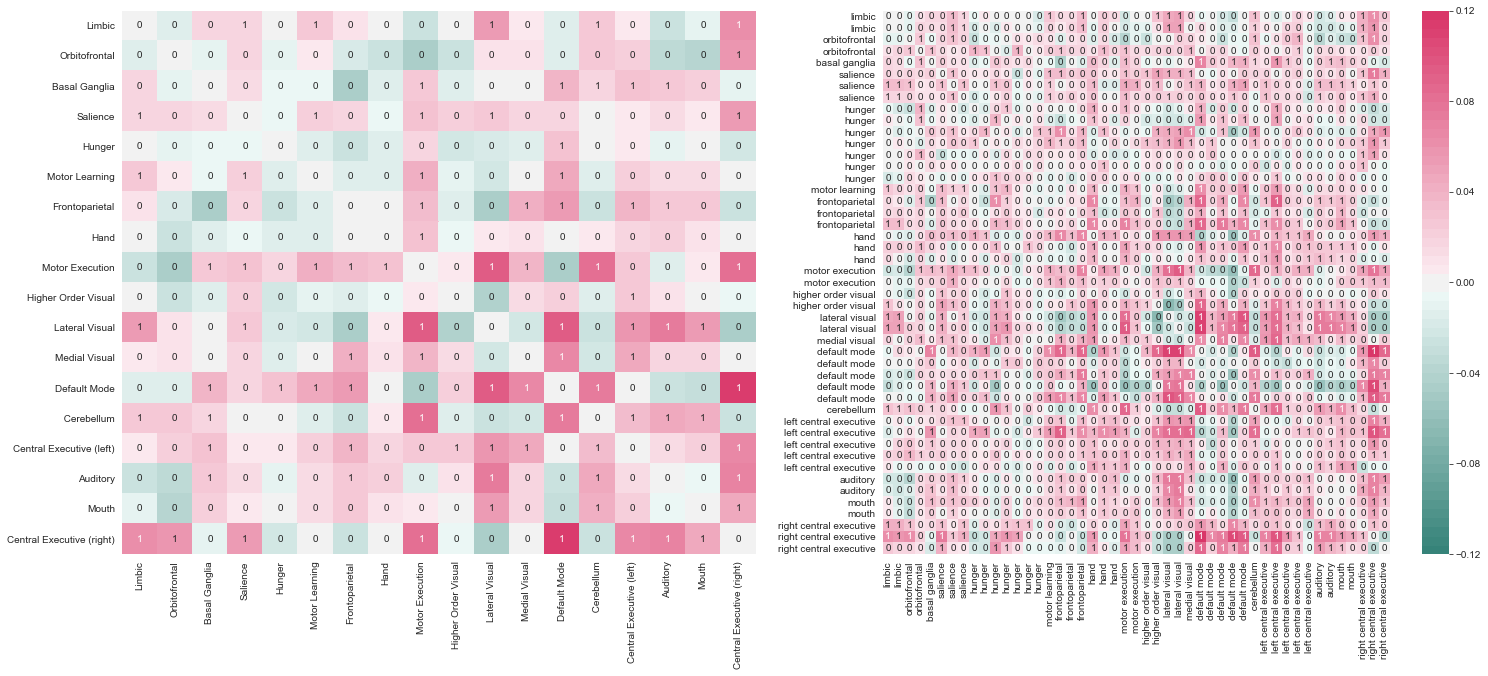

In [116]:
diff_r = (corrmats_r['gen'] - corrmats_r['phy']) / 105
diff = (corrmats['gen'] - corrmats['phy']) / 107

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
g = sns.heatmap(diff, xticklabels=ntwk_labels, yticklabels=ntwk_labels, ax=axes[0], 
                vmin=-0.12, vmax=0.12, annot=gen_gt_phy_ntwk, cmap=hustler, cbar=False)
g = sns.heatmap(diff_r, xticklabels=regn_labels, yticklabels=regn_labels, ax=axes[1], 
                vmin=-0.12, vmax=0.12, annot=gen_gt_phy_regn, cmap=hustler)

In [149]:
colors = ['#d2416a', '#c3553e', '#a36a3d', '#91723d', '#82783d', '#727c3d', 
          '#5c813c', '#3d854c', '#3f8467', '#408275', '#418180', '#42808b', 
          '#447e98', '#477ab1', '#6b6bd6', '#9f53d6', '#b649bd', '#c146a5']

In [151]:
lut = dict(zip(gen_gt_phy_regn.index.unique(), colors))
row_colors = map(lut, regn_labels)

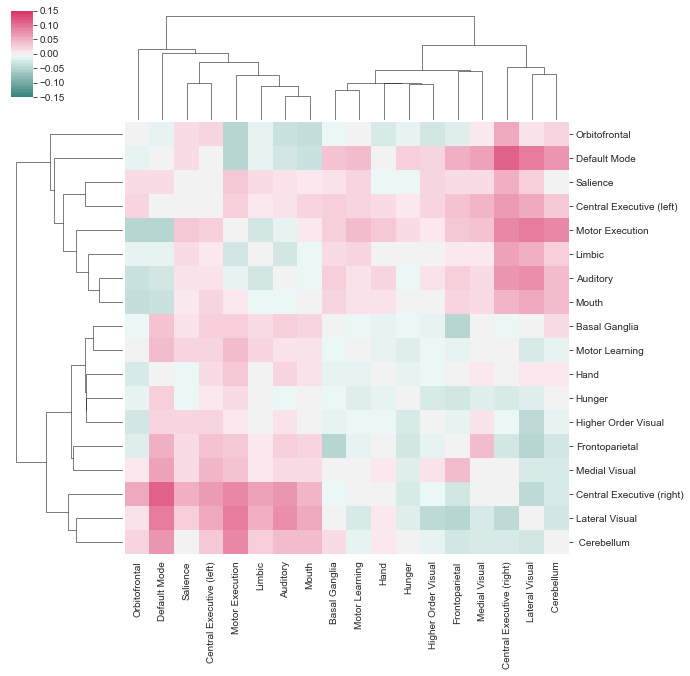

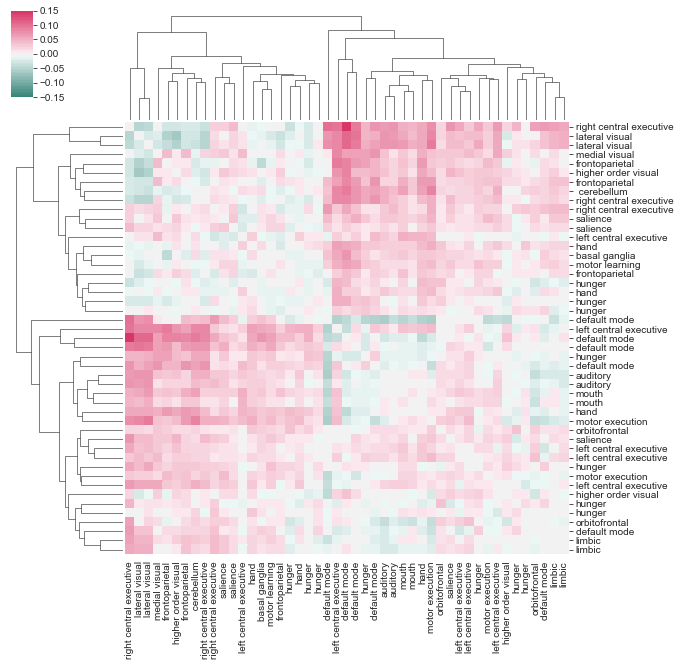

In [163]:
#fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
g = sns.clustermap(diff, xticklabels=ntwk_labels, yticklabels=ntwk_labels, 
                   vmin=-0.15, vmax=0.15, cmap=hustler)
g = sns.clustermap(diff_r, xticklabels=regn_labels, yticklabels=regn_labels, 
                   vmin=-0.15, vmax=0.15, cmap=hustler)

In [33]:
import bct

In [158]:
cent_subgraph_all = bct.betweenness_bin(gen_gt_phy_ntwk)

In [164]:
ntwk_cent = pd.Series(cent_subgraph_all, index=ntwk_labels)

In [165]:
cent_subgraph_regn = bct.betweenness_bin(gen_gt_phy_regn)
regn_cent = pd.Series(cent_subgraph_regn, index=regn_labels)

AttributeError: module 'bct' has no attribute 'version'